In [ ]:
# import common libs
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from pyspark.sql.types import *

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Import the evaluation submodule
import pyspark.ml.evaluation as evals

# Import LogisticRegression
from pyspark.ml.classification import LogisticRegression

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession \
        .builder \
        .master("local[*]") \
        .config("spark.executor.memory", "16g") \
        .config("spark.driver.memory", "16g") \
        .config("spark.memory.offHeap.enabled",True) \
        .config("spark.memory.offHeap.size","16g") \
        .appName("Airline") \
        .getOrCreate()


        # .config("spark.sql.shuffle.partitions",60) \

##### Importing Dataframe

In [18]:
flights_df = spark.read.option("header",True).csv('Data_Dump/data/flights/2013.csv')
flights_df.createOrReplaceTempView("Flights")
flights_df=flights_df.select([when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c),0).otherwise(col(c)).alias(c) for c in flights_df.columns])
#checking if the file has any NaN values
flights_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in flights_df.columns]).show()


+-------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+-------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|      0| 

In [8]:
flights_df.count()

6369482

##### Cleaning Dataframe

In [19]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

replaceCols=['OP_CARRIER','OP_CARRIER_FL_NUM','ORIGIN','DEST','CRS_DEP_TIME','DEP_DELAY','CRS_ARR_TIME','DIVERTED','CANCELLED','ARR_DELAY','ARR_TIME','DISTANCE','ACTUAL_ELAPSED_TIME','AIR_TIME','TAXI_IN','TAXI_OUT']
df=flights_df.select([when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c),0).otherwise(col(c)).alias(c) for c in replaceCols])

df = df.withColumn("DISTANCE", df["DISTANCE"].cast(IntegerType()))
df = df.withColumn("ARR_TIME", df["ARR_TIME"].cast(IntegerType()))
df = df.withColumn("ARR_DELAY", df["ARR_DELAY"].cast(IntegerType()))
df = df.withColumn("CANCELLED", df["CANCELLED"].cast(IntegerType()))
df = df.withColumn("DIVERTED", df["DIVERTED"].cast(IntegerType()))
df = df.withColumn("CRS_ARR_TIME", df["CRS_ARR_TIME"].cast(IntegerType()))
df = df.withColumn("CRS_DEP_TIME", df["CRS_DEP_TIME"].cast(IntegerType()))
df = df.withColumn("OP_CARRIER_FL_NUM", df["OP_CARRIER_FL_NUM"].cast(IntegerType()))
df = df.withColumn("DEP_DELAY", df["DEP_DELAY"].cast(IntegerType()))

df.createOrReplaceTempView("fl_df")
query="select * from fl_df where DEP_DELAY<=150" #outliers
df=spark.sql(query)



##### Encoding Labels

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
fl_df=df.toPandas()
fl_df['OP_CARRIER']= le.fit_transform(fl_df['OP_CARRIER'])
fl_df['ORIGIN'] = le.fit_transform(fl_df['ORIGIN'])
fl_df['DEST'] = le.fit_transform(fl_df['DEST'])


In [6]:
X = fl_df.drop(['DEP_DELAY','CRS_DEP_TIME','OP_CARRIER_FL_NUM','ARR_TIME'],axis = 1)
X.shape
y = fl_df['DEP_DELAY']
y.head()


0    0
1   -1
2   -1
3    0
4    4
Name: DEP_DELAY, dtype: int32

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state = 5)


In [8]:
sc1=StandardScaler()
X_train_sc=sc1.fit_transform(X_train)
X_test_sc=sc1.transform(X_test)

### Boosted Linear Regression: Ada Boost

In [19]:
from sklearn.ensemble import AdaBoostRegressor
Boost_Lin = AdaBoostRegressor(base_estimator=LinR,random_state=2)

fitResultBl = Boost_Lin.fit(X_train_sc,y_train)
predictedValues = fitResultBl.predict(X_test_sc)
print ('MAE:' ,  mean_absolute_error(y_test, predictedValues))
print ('MSE:' , mean_squared_error(y_test, predictedValues))
print('RMSE:' , np.sqrt(mean_squared_error(y_test, predictedValues)))
print ('R2:' , r2_score(y_test, predictedValues))



MAE: 11.009053409304611
MSE: 242.58325019101613
RMSE: 15.575084275567056
R2: 0.5611429499382903


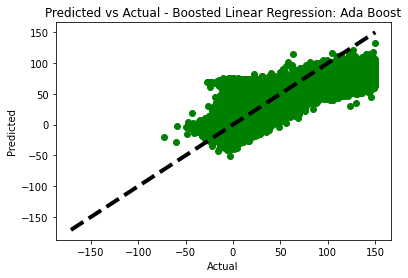

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_test, predictedValues,color='green')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title("Predicted vs Actual - Boosted Linear Regression: Ada Boost")

plt.show() 



### Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression
LinR = LinearRegression()
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

fitResult = LinR.fit(X_train_sc,y_train)
y_pred = fitResult.predict(X_test_sc)
print ('MAE:' ,  mean_absolute_error(y_test, y_pred))
print ('MSE:' , mean_squared_error(y_test, y_pred))
print('RMSE:' , np.sqrt(mean_squared_error(y_test, y_pred)))
print ('R2:' , r2_score(y_test, y_pred))


MAE: 6.170999143951996
MSE: 71.5234776119783
RMSE: 8.45715540900002
R2: 0.8706069674215702


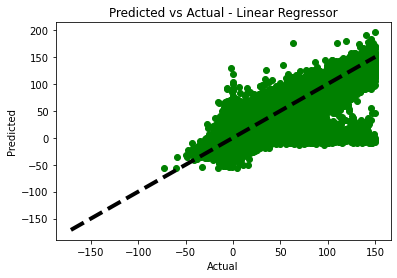

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred,color='green')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title("Predicted vs Actual - Linear Regressor")
plt.show() 



### Decision Tree Regressor

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

Dtc = DecisionTreeRegressor(random_state = 2)
fitResultdtc = Dtc.fit(X_train_sc,y_train)
predictedValues = fitResultdtc.predict(X_test_sc)
print ('MAE:' ,  mean_absolute_error(y_test, predictedValues))
print ('MSE:' , mean_squared_error(y_test, predictedValues))
print('RMSE:' , np.sqrt(mean_squared_error(y_test, predictedValues)))
print ('R2:' , r2_score(y_test, predictedValues))



MAE: 4.8164305314622355
MSE: 59.62379502999317
RMSE: 7.72164458065723
R2: 0.8921346680789263


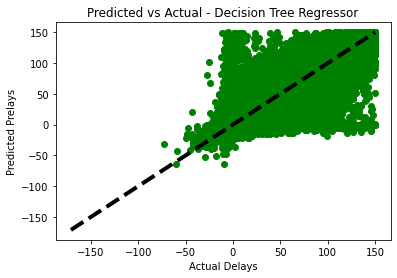

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_test, predictedValues, color='green')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual Delays')
ax.set_ylabel('Predicted Prelays')
plt.title("Predicted vs Actual - Decision Tree Regressor")
plt.show() 


In [31]:
import pickle
#saving the three models
pickle.dump(fitResult, open('modelLinearReg.pkl', 'wb'))
pickle.dump(fitResultBl, open('modelAdaBoost.pkl', 'wb'))
pickle.dump(fitResultdtc, open('modelDecision.pkl', 'wb'))

### Logistic regression


In [ ]:
# has a huge runtime so killed by ilab each time

# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression(random_state = 5)
# classifier.fit(X_train_sc, y_train)

# y_pred = classifier.predict(X_test_sc)

# # Making the Confusion Matrix
# score = classifier.score(X_test_sc,y_test)
# #cm = confusion_matrix(y_test, y_pred)


### K nearest neighbours classifier



In [ ]:
# #has a huge runtime so killed by ilab each time
# from sklearn.neighbors import KNeighborsClassifier
# objClassifier=KNeighborsClassifier(n_neighbors=10,metric='minkowski',p=2)
# objClassifier.fit(X_train_sc,y_train)

# y_pred=objClassifier.predict(X_test_sc)

# #Making the confussion matarix 

# from sklearn.metrics import confusion_matrix
# cm=confusion_matrix(y_test,y_pred)

# score=objClassifier.score(X_test,y_test)


In [14]:
import _pickle as cPickle
#file = pickle.load('modelAdaBoost.pkl')
with open(r"modelAdaBoost.pkl", "rb") as input_file:
    e = cPickle.load(input_file)

In [16]:
print(e([1,2,3,4]))

TypeError: 'AdaBoostRegressor' object is not callable